In [ ]:
!pip install torchutils

In [ ]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T

# Для чтения изображений с диска
from torchvision import io # input/output
import torchutils as tu
import json
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
config = {
    'batch_size': 512,
    'learning_rate': 0.003,
    'epochs': 15,
    'device': 'cuda',
    'data_dir': 'data/',
    'log_dir': 'runs/experiment1'
}

DEVICE = config['device']

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/blood-cells")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'blood-cells' dataset.
Path to dataset files: /kaggle/input/blood-cells


In [ ]:
train_trans = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(degrees=10),
    T.ToTensor(),
    T.Normalize(mean=[0.5169, 0.5246, 0.5059], std=[0.1900, 0.1839, 0.1903])
])

valid_trans = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.5169, 0.5246, 0.5059], std=[0.1900, 0.1839, 0.1903])
])

train_dataset = torchvision.datasets.ImageFolder('/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN',
                                                 transform=train_trans)


valid_dataset = torchvision.datasets.ImageFolder('/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST',
                                                 transform=valid_trans)

train_dataset

Dataset ImageFolder
    Number of datapoints: 9957
    Root location: /kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.5169, 0.5246, 0.5059], std=[0.19, 0.1839, 0.1903])
           )

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=True)

In [ ]:
from torchvision.models import efficientnet_v2_m, EfficientNet_V2_M_Weights

weights = EfficientNet_V2_M_Weights.DEFAULT
model = efficientnet_v2_m(weights=weights).to(DEVICE)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
model.classifier[1] = nn.Linear(1280, 4)

In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
for layer in model.features[-2:]:
    for param in layer.parameters():
        param.requires_grad = True

for param in model.classifier[1].parameters():
    param.requires_grad = True

In [ ]:
model.to(DEVICE)
tu.get_model_summary(model, torch.randn(32, 3, 224, 224, device=DEVICE))

Layer                                                      Kernel               Output          Params             FLOPs
0_features.0.Conv2d_0                                     [3, 24, 3, 3]   [32, 24, 112, 112]         648     260,112,384
1_features.0.BatchNorm2d_1                                         [24]   [32, 24, 112, 112]          48      38,535,168
2_features.0.SiLU_2                                                   -   [32, 24, 112, 112]           0               0
3_features.1.0.block.0.Conv2d_0                          [24, 24, 3, 3]   [32, 24, 112, 112]       5,184   2,080,899,072
4_features.1.0.block.0.BatchNorm2d_1                               [24]   [32, 24, 112, 112]          48      38,535,168
5_features.1.0.block.0.SiLU_2                                         -   [32, 24, 112, 112]           0               0
6_features.1.0.StochasticDepth_stochastic_depth                       -   [32, 24, 112, 112]           0               0
7_features.1.1.block.0.Conv2d_0 

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=config['learning_rate'])

In [ ]:
def compute_batch_accuracy(preds, labels):
    predicted_classes = preds.argmax(dim=1)
    correct = (predicted_classes == labels).sum()
    accuracy = correct.float() / labels.size(0)
    return accuracy.item()

[Epoch 00] Train loss: 0.6159, valid loss = 1.9714 Train acc 0.7467 Valid acc 0.8421
[Epoch 01] Train loss: 0.0947, valid loss = 1.1263 Train acc 0.9655 Valid acc 0.8009
[Epoch 02] Train loss: 0.0380, valid loss = 1.2686 Train acc 0.9864 Valid acc 0.8645
[Epoch 03] Train loss: 0.0327, valid loss = 1.3436 Train acc 0.9890 Valid acc 0.8186


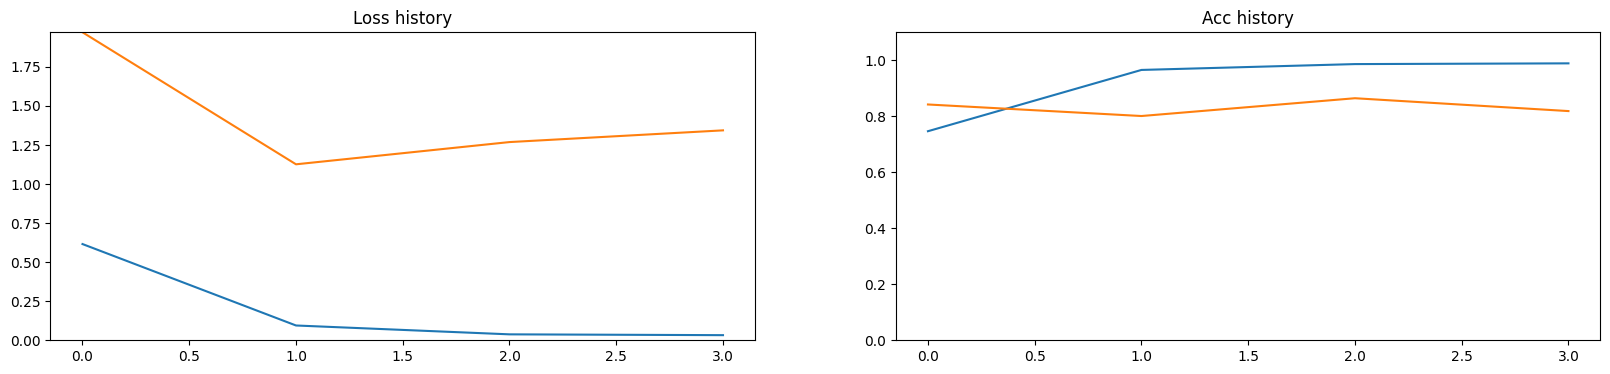

In [ ]:
model.to(DEVICE)

train_loss_hist = []
valid_loss_hist = []
train_acc_hist = []
valid_acc_hist = []

for epoch in range(4):

    loss_batch = []
    acc_batch = []

    model.train()
    for images, labels in train_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        preds = model(images)

        loss = criterion(preds, labels)

        loss_batch.append(loss.item())
        acc_batch.append(compute_batch_accuracy(preds, labels))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss_hist.append(np.mean(loss_batch))
    train_acc_hist.append(np.mean(acc_batch))

    model.eval()
    loss_batch = []
    acc_batch  = []

    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            preds = model(images)

            loss = criterion(preds, labels)
            loss_batch.append(loss.item())
            acc_batch.append(compute_batch_accuracy(preds, labels))


    valid_loss_hist.append(np.mean(loss_batch))
    valid_acc_hist.append(np.mean(acc_batch))
    print(f'[Epoch {epoch:02d}] Train loss: {train_loss_hist[-1]:.4f}, valid loss = {valid_loss_hist[-1]:.4f} Train acc {train_acc_hist[-1]:.4f} Valid acc {valid_acc_hist[-1]:.4f}')

fig, ax = plt.subplots(1, 2, figsize=(20, 4))
ax[0].plot(train_loss_hist)
ax[0].plot(valid_loss_hist)
all_losses = train_loss_hist + valid_loss_hist
ax[0].set_ylim((0, max(all_losses)))
ax[0].set_title('Loss history')

ax[1].plot(train_acc_hist)
ax[1].plot(valid_acc_hist)
ax[1].set_ylim(0, 1.1)
ax[1].set_title('Acc history');

In [ ]:
torch.save(model.state_dict(), "efficientnet_blood_model.pth")

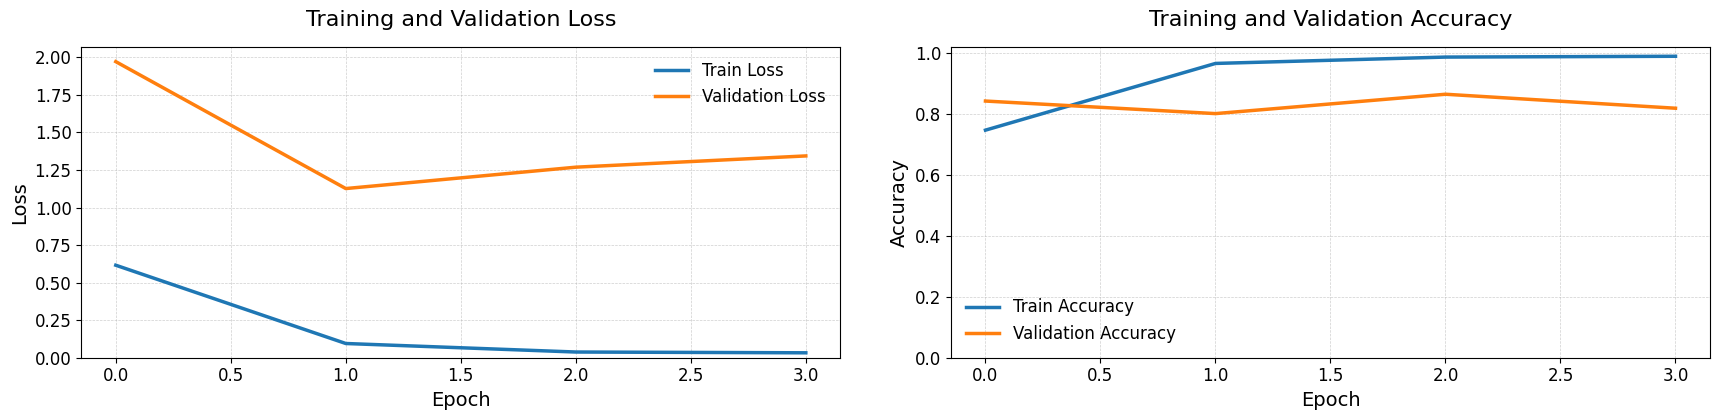

In [ ]:
import matplotlib.pyplot as plt

# Настройка стиля
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'legend.fontsize': 12,
    'figure.titlesize': 16,
    'grid.linewidth': 0.5,
    'lines.linewidth': 2.5
})

fig, ax = plt.subplots(1, 2, figsize=(18, 5))

# Цвета
train_color = '#1f77b4'  # синий (стандартный, но аккуратный)
valid_color = '#ff7f0e'  # оранжевый

# --- Loss ---
ax[0].plot(train_loss_hist, label='Train Loss', color=train_color)
ax[0].plot(valid_loss_hist, label='Validation Loss', color=valid_color)
ax[0].set_title('Training and Validation Loss', fontsize=16, pad=15)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(frameon=False)
ax[0].grid(True, linestyle='--', alpha=0.6)
ax[0].set_ylim(0, max(train_loss_hist + valid_loss_hist) * 1.05)

# --- Accuracy ---
ax[1].plot(train_acc_hist, label='Train Accuracy', color=train_color)
ax[1].plot(valid_acc_hist, label='Validation Accuracy', color=valid_color)
ax[1].set_title('Training and Validation Accuracy', fontsize=16, pad=15)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_ylim(0, 1.02)
ax[1].legend(frameon=False)
ax[1].grid(True, linestyle='--', alpha=0.6)

# Улучшение макета
plt.tight_layout(pad=3.0)

# Сохранение в высоком качестве
plt.savefig('training_history_blood.png', dpi=300, bbox_inches='tight')

# Показать график (опционально)
plt.show()